LSTM

In [ ]:
pip install numpy torch pmdarima seaborn scipy

In [1]:
# library imports
from nowcast_lstm.LSTM import LSTM
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# Updated function to generate lagged data
def gen_lagged_data(metadata, data, last_date, lag):
    last_date = pd.Timestamp(last_date)  # Ensure last_date is a Timestamp object
    lagged_data = data.loc[data.index <= last_date, :].reset_index()
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        
        lagged_data.loc[(len(lagged_data) - pub_lag - lag):, col] = np.nan

    return lagged_data


# Data set up

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm
from pathlib import Path
import os

project_dir = Path(os.getcwd()).parent

# Define the path to the raw data folder relative to the project directory
data_dir = project_dir / 'data' / 'data_files' / 'processed_data'

# Read data
metadata = pd.read_csv(data_dir / 'meta_monthly_blocks_2.csv')
data = pd.read_csv(data_dir / 'deseasonalized_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

# Function to standardize a single column
def z_score(x):
    return (x - x.mean()) / x.std()

normalized = data.copy()

normalized.loc[:, normalized.columns != 'date'] = normalized.loc[:, normalized.columns != 'date'].apply(z_score)

data = normalized

target_variable = "China: GDP: Current Prices:PoP GROWTHRATE"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
# Define date ranges
train_start_date = pd.to_datetime('1992-06-30')
test_start_date = pd.to_datetime("2018-06-30")
test_end_date = pd.to_datetime("2023-12-31")
dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QE')
print(dates)

# train and test datasets
test = data.loc[(data.index >= train_start_date) & (data.index <= test_end_date), :]
test.tail()

DatetimeIndex(['2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31',
               '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31',
               '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31',
               '2021-06-30', '2021-09-30', '2021-12-31', '2022-03-31',
               '2022-06-30', '2022-09-30', '2022-12-31', '2023-03-31',
               '2023-06-30', '2023-09-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='QE-DEC')


China: Financial Institutions: Total Deposits Balance: RMB:PoP GROWTHRATE  \
date                                                                                    
2023-08-31                                           0.060614                           
2023-09-30                                           0.090164                           
2023-10-31                                           0.023585                           
2023-11-30                                           0.039272                           
2023-12-31                                          -0.762501                           

            China: Industrial Added Value Above Designated Size: YoY  \
date                                                                   
2023-08-31                                           0.084946          
2023-09-30                                          -0.003022          
2023-10-31                                           0.047531          
2023-11-30                                           0.332335          
2023-12-31                                          -0.033569          

            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-08-31                       -0.454623   
2023-09-30                       -0.047017   
2023-10-31                       -0.002207   
2023-11-30                       -0.088482   
2023-12-31                       -1.287662   

            Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg  \
date                                                                              
2023-08-31                                          -0.807297                     
2023-09-30                                          -0.808093                     
2023-10-31                                          -1.798280                     
2023-11-30                                          -0.162833                     
2023-12-31                                           0.181796                     

            China: Urban Surveyed Unemployed Rate: Mean:PoP chg  \
date                                                              
2023-08-31                                          -0.442230     
2023-09-30                                          -0.167179     
2023-10-31                                          -0.055216     
2023-11-30                                           0.261572     
2023-12-31                                           1.141768     

            China: No. of New Employed Persons in Urban Areas: YTD:PoP GROWTHRATE  \
date                                                                                
2023-08-31                                           0.019708                       
2023-09-30                                           0.003760                       
2023-10-31                                          -0.262980                       
2023-11-30                                           0.544832                       
2023-12-31                                           0.550101                       

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-08-31                                           0.200391      
2023-09-30                                           0.489073      
2023-10-31                                           0.201125      
2023-11-30                                          -0.626020      
2023-12-31                                          -0.403374      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-08-31                                           0.188619        
2023-09-30                                           0.419931        
2023-10-31                                           0.500554        
2023-11-30                                          -0.761091        
2023-12-31     

# Training the model

The model is trained on a rolling basis. So if we are predicting 2000-03-01, the model is trained on data as it would have appeared in 1999-12-01, right before the beginning of the prediction period.

# Testing the model on artificial data vintages

In [7]:
# actual values
actuals = list(test.loc[test.index.isin(dates), target_variable].values)
print(actuals)

[-0.6849544085679198, -0.6119740413652863, -0.4937444195250279, 0.14129623211839917, -0.5812296108463308, -0.8443222777951667, -0.5294662966751601, -3.899152536397687, 2.1768945393715646, -0.06971581206223539, -0.06798737852039938, 0.2916892526383249, 0.08690145628979003, -1.1500736573973596, -0.05162882489869327, -0.23359300515086423, -1.4837020948866197, -0.42376242422524707, -1.0668949285241651, 0.6237542346168391, -1.4183121861574457, -0.8952756846140533, -0.9872301403930471]


In [8]:
# Define lags as 0, 1, 2, and 3 months
lags = [0, 1, 2, 3]

pred_dict = {k: [] for k in lags}
for date in dates:
    for lag in lags:
        # Calculate the cut-off date for training data, ensuring no future data is included
        train_cutoff_date = pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=lag + 1)
        
        # Filter the training data to include only data up to the cutoff date
        train = test.loc[test.index <= train_cutoff_date].copy()
        train = train.reset_index()
        
        # Train the model on this non-contaminated data
        model = LSTM(
            data = train,
            target_variable = target_variable,
            n_timesteps = 6,
            fill_na_func = np.nanmean,
            fill_ragged_edges_func = np.nanmean,
            n_models = 10,
            train_episodes = 50,
            batch_size = 50,
            decay = 0.98,
            n_hidden = 40,
            n_layers = 2,
            dropout = 0.0,
            criterion = torch.nn.MSELoss(),
            optimizer = torch.optim.Adam,
            optimizer_parameters = {"lr":1e-2, "weight_decay":0.0}
        )
        model.train(quiet=False)
        
        # Generate the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)
        print(tmp_data)
        
        # Ensure the 'date' column is correctly formatted
        if 'date' in tmp_data.columns:
            tmp_data['date'] = pd.to_datetime(tmp_data['date'], errors='coerce')
        else:
            raise ValueError("The 'tmp_data' DataFrame does not have a 'date' column.")
        
        # The predict function will give a whole dataframe, only interested in the prediction for this date
        pred = model.predict(tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
        pred_dict[lag].append(pred)


Training model 1
step :  0 loss :  0.4074087142944336
step :  1 loss :  0.030415721237659454
step :  2 loss :  1.0602508783340454
step :  3 loss :  0.05691203847527504
step :  4 loss :  0.0711439847946167
step :  5 loss :  0.07229571044445038
step :  6 loss :  0.038672879338264465
step :  7 loss :  0.014671488665044308
step :  8 loss :  0.01137666217982769
step :  9 loss :  0.007367621175944805
step :  10 loss :  0.011215632781386375
step :  11 loss :  0.0006003665621392429
step :  12 loss :  0.005950052756816149
step :  13 loss :  0.0019152903696522117
step :  14 loss :  0.0006145946681499481
step :  15 loss :  0.0019419539021328092
step :  16 loss :  0.0008178347488865256
step :  17 loss :  0.0004722279845736921
step :  18 loss :  0.0011044832644984126
step :  19 loss :  0.0001962960377568379
step :  20 loss :  0.0008065848960541189
step :  21 loss :  0.00020487539586611092
step :  22 loss :  2.880716056097299e-05
step :  23 loss :  0.00013033958384767175
step :  24 loss :  6.1656523

  Vintage    RMSE
0       0  1.2152
1       1  1.2620
2       2  1.2333
3       3  1.2447


/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_67548/4048293938.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp], ignore_index=True)


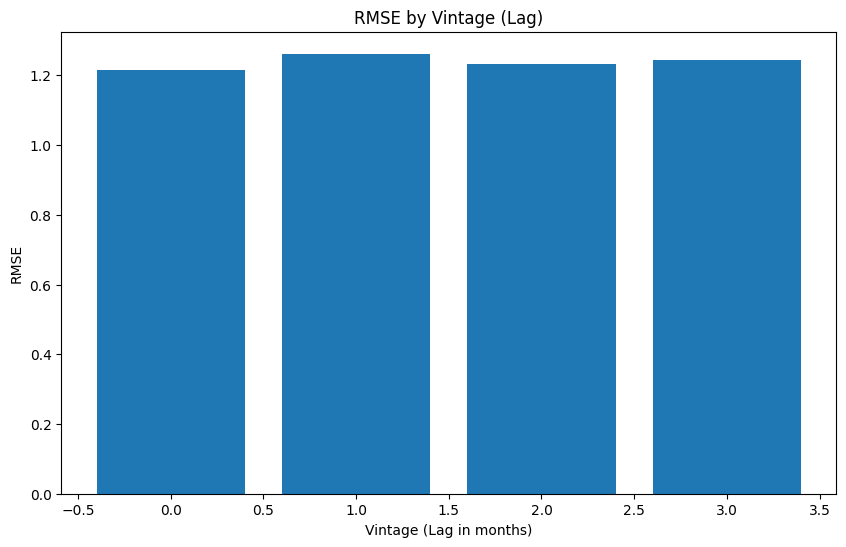

In [9]:
# Calculate RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])

# Ensure actuals and predictions are aligned
actuals = data.loc[dates, target_variable]

for lag in lags:
    predictions = pred_dict[lag]
    
    # Remove any NaN values (where predictions weren't made)
    mask = ~(np.isnan(actuals) | np.isnan(predictions))
    actuals_clean = actuals[mask]
    predictions_clean = np.array(predictions)[mask]
    
    rmse = np.sqrt(np.mean((actuals_clean - predictions_clean) ** 2))
    
    tmp = pd.DataFrame({
        "Vintage": [lag],
        "RMSE": [rmse]
    })
    performance = pd.concat([performance, tmp], ignore_index=True)

performance = performance.sort_values("Vintage").reset_index(drop=True)
print(performance.round(4))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(performance['Vintage'], performance['RMSE'])
plt.title('RMSE by Vintage (Lag)')
plt.xlabel('Vintage (Lag in months)')
plt.ylabel('RMSE')
plt.show()

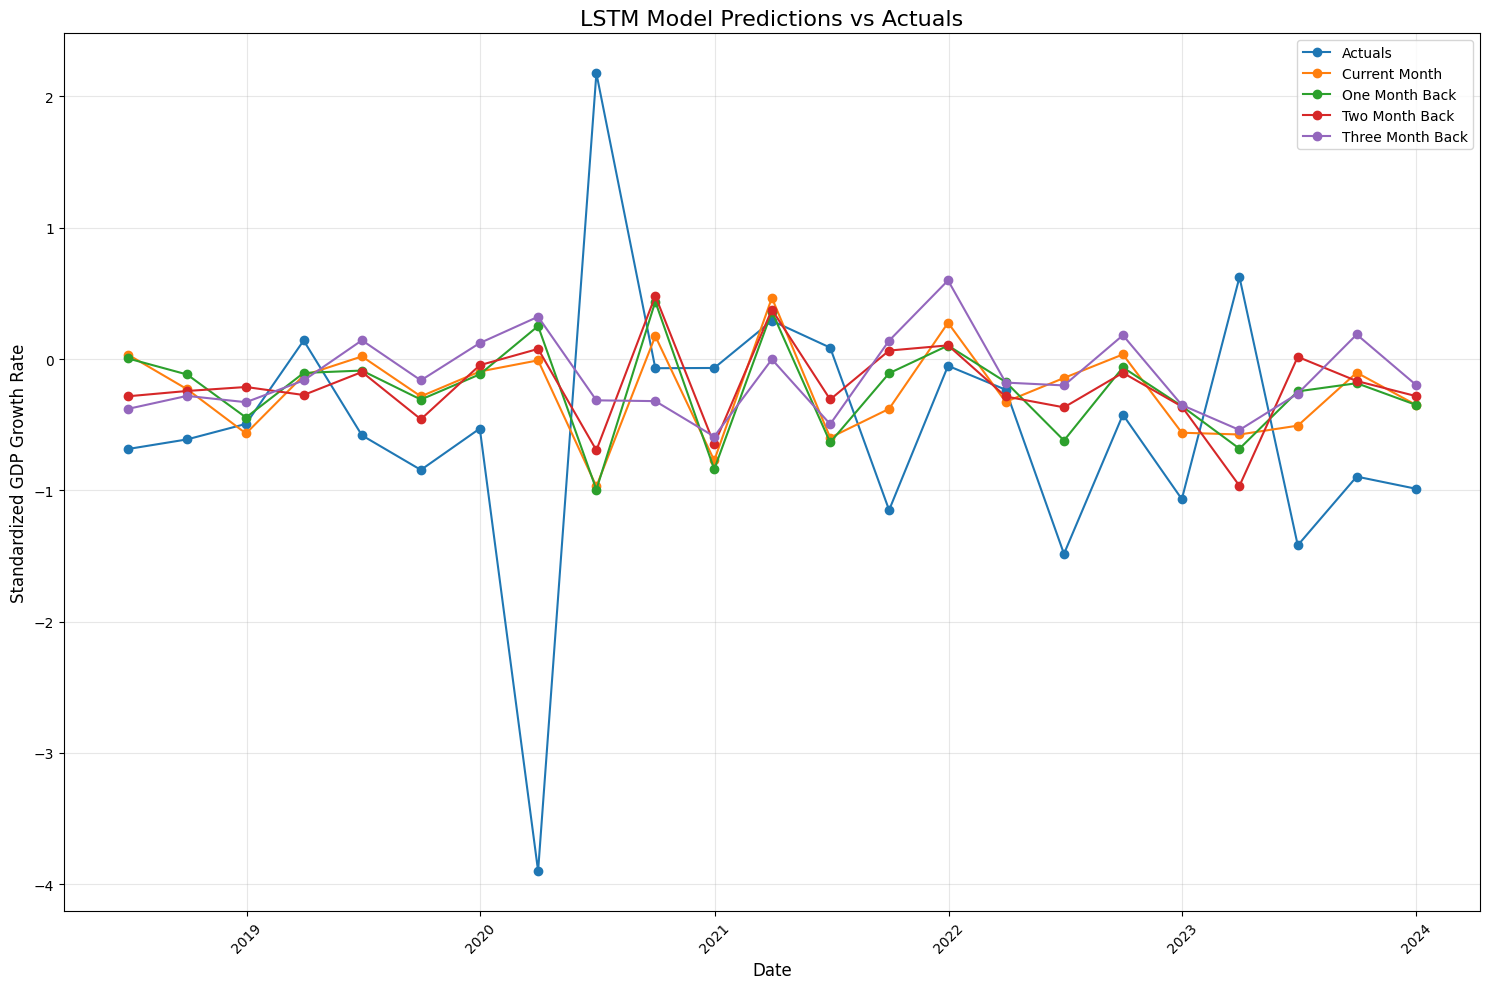

In [10]:
# Plot of predictions vs actuals
plt.figure(figsize=(15, 10))
df = pd.DataFrame({
    "Actuals": actuals,
    "Current Month": pred_dict[0],
    "One Month Back": pred_dict[1],
    "Two Month Back": pred_dict[2],
    "Three Month Back": pred_dict[3]
})

for column in df.columns:
    plt.plot(dates, df[column], label=column, marker='o')

plt.title("LSTM Model Predictions vs Actuals", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Standardized GDP Growth Rate", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Assess and visualize model performance

In [11]:
import pandas as pd
from datetime import datetime

# Convert pred_dict to a DataFrame
df = pd.DataFrame(pred_dict)

# Add a date column
df['date'] = dates

# Reorder columns to have date first
columns = ['date'] + [col for col in df.columns if col != 'date']
df = df[columns]

# Save to CSV with timestamp
filename = f'lstm_deseason.csv'
df.to_csv(project_dir / 'results' / filename, index=False)

# Hyperparameter tuning
The process is carried out remotely using a gpu to speed up the process. The results are recorded here. Adjust the parameters according to specific usage.

Results:
{-2: 0.2644906125086237, -1: 0.1765942165320782, 0: 0.1737544684232222, 1: 0.0771388893971711, 2: 0.0366360014505986}
{-2: 'n_timesteps_6_n_hidden_40_n_layers_4_batch_size_200_train_episodes_50', -1: 'n_timesteps_6_n_hidden_40_n_layers_4_batch_size_200_train_episodes_100', 0: 'n_timesteps_6_n_hidden_40_n_layers_4_batch_size_200_train_episodes_200', 1: 'n_timesteps_3_n_hidden_10_n_layers_2_batch_size_100_train_episodes_50', 2: 'n_timesteps_3_n_hidden_10_n_layers_1_batch_size_50_train_episodes_100'}


In [ ]:
import torch
import pandas as pd
import numpy as np
from itertools import product

# Define the hyperparameter grid
param_grid = {
    'n_timesteps': [3, 6, 12],
    'n_hidden': [10, 20, 40],
    'n_layers': [1, 2, 4],
    'batch_size': [50, 100, 200],
    'train_episodes': [50, 100, 200]
}

# Initialize the prediction dictionary
pred_dict = {k: [] for k in lags}
best_score = float('inf')
best_params = None

total_combinations = np.prod([len(v) for v in param_grid.values()])
combination_count = 0

print(f"Total hyperparameter combinations: {total_combinations}")

# Iterate through all combinations of the hyperparameters
for params in product(*param_grid.values()):
    combination_count += 1
    params_dict = dict(zip(param_grid.keys(), params))

    print(f"\nTesting combination {combination_count}/{total_combinations}")
    print(f"Current parameters: {params_dict}")

    # Temporary list to hold predictions for the current hyperparameter combination
    temp_pred_dict = {k: [] for k in lags}

    for date in dates:
        # Prepare the training data
        train = test.loc[test.index <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10], :]
        train = train.reset_index()

        for n_timesteps in param_grid['n_timesteps']:
            for n_hidden in param_grid['n_hidden']:
                for n_layers in param_grid['n_layers']:
                    for batch_size in param_grid['batch_size']:
                        for train_episodes in param_grid['train_episodes']:

        # Train the LSTM model with the current hyperparameters
                            model = LSTM(
                                data=train,
                                target_variable=target_variable,
                                n_timesteps=n_timesteps,
                                fill_na_func=np.nanmean,
                                fill_ragged_edges_func=np.nanmean,
                                n_models=10,
                                train_episodes=train_episodes,
                                batch_size=batch_size,
                                decay=0.98,
                                n_hidden=n_hidden,
                                n_layers=n_layers,
                                dropout=0.0,
                                criterion=torch.nn.MSELoss(),
                                optimizer=torch.optim.Adam,
                                optimizer_parameters={"lr": 1e-2, "weight_decay": 0.0}
                            )
                            model.train(quiet=True)
        # Predict for each lag
        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test, date, lag)
            
            # the predict function will give a whole dataframe, only interested in the prediction for this date
            pred = model.predict(tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
            pred_dict[lag].append(pred)

    # Evaluate the performance of the current hyperparameter combination
    # Assuming you have a function to calculate RMSE across all dates and lags
    current_score = np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    print(f"Current RMSE: {current_score:.4f}")

    # Update the best model if the current one is better
    if current_score < best_score:
        best_score = current_score
        best_params = params_dict
        pred_dict = temp_pred_dict.copy()  # Save the best predictions
        print(f"New best score found: {best_score:.4f}")

print("Best parameters found:", best_params)
print("Best score (RMSE):", best_score)
